# Classifying cell types with neural networks

**Overview:** In this Python based Colab notebook, we will build a neural network that classifies cell types in the retinal bipolar dataset from [Shekhar et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27565351/). The cells in this set have been manually annotated with their cell type. You can find more information about how this annotation was done in the original paper. 

*Here, we will show that a neural network can recapitulate these cell type labels.*

**Background:** Accurately being able to identify different cell types is highly important for investigating development, function, and disease. Knowing what each cell types role is or what genes are important to that type allows fundamental processes to be understood with greater precision. 

Retinal Bipolar Cells (BCs) transmit signals between the photoreceptors and the ganglion cells. Bipolar cells are a class of interneuron cell. BCs receive synaptic input from rod and cone photoreceptors, process it in diverse ways, and transmit it to retinal ganglion cells (RGCs), which in turn send axons to the rest of the brain.  BCs have been divided into 9–12 types, initially by morphological features, which were later related to physiological and, in some cases, molecular properties (From Shekhar, 2016)

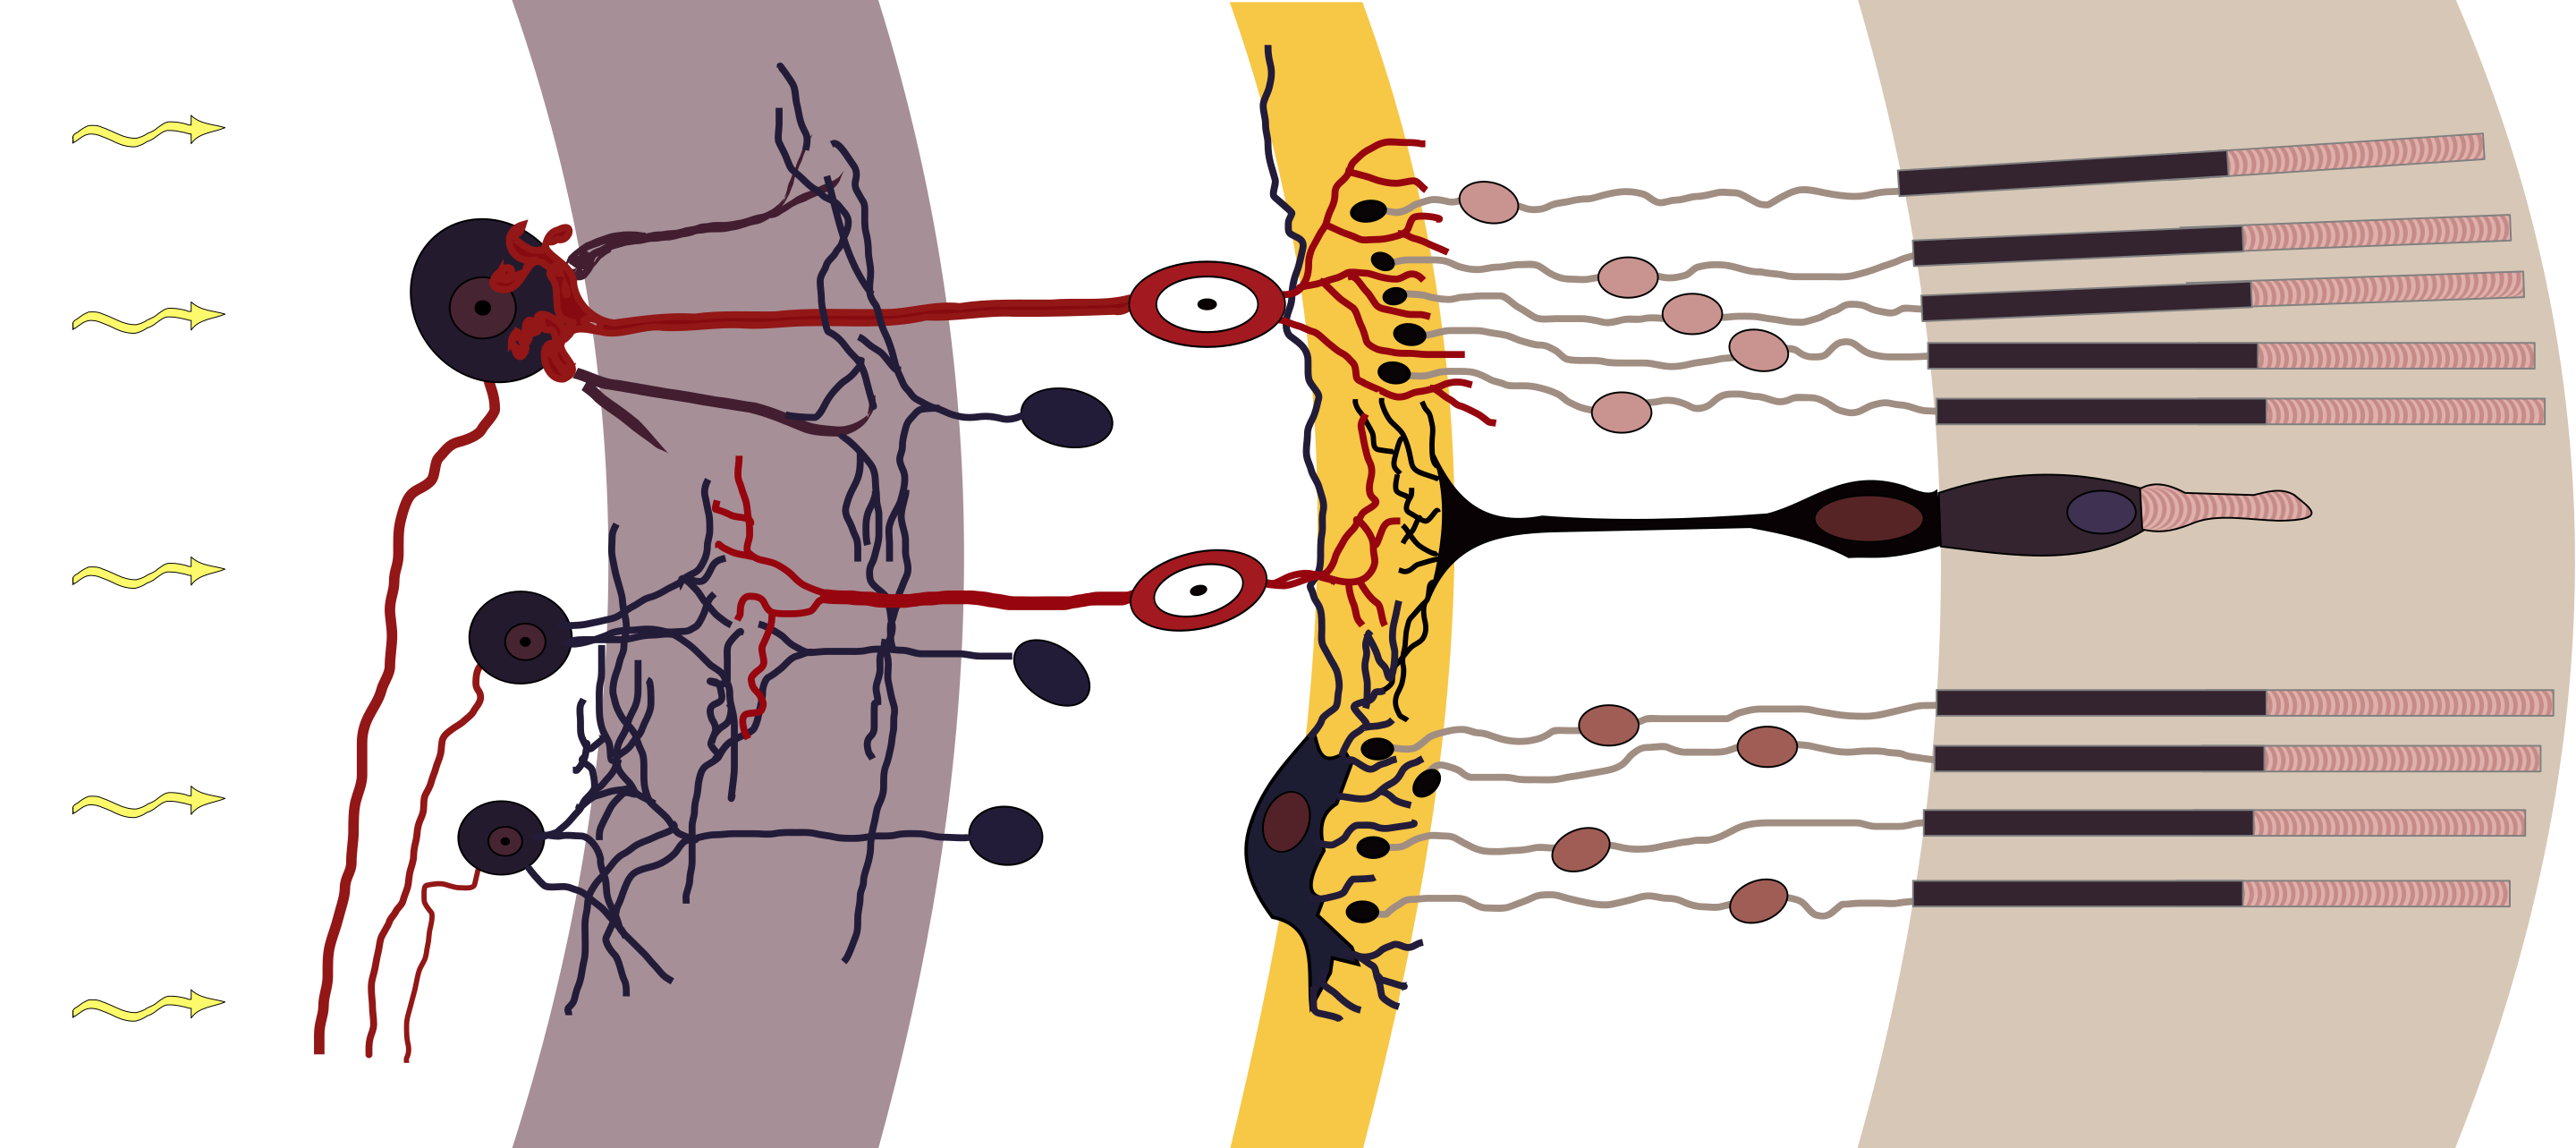

This image shows the retina with the bipolar cells in red. Image: Wikipedia

Overview:

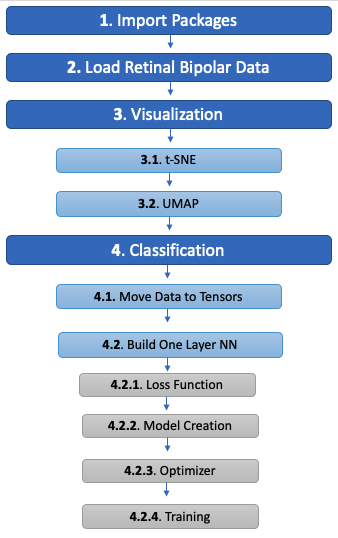

## 1.Imports

In [ ]:
!pip install scprep

In [ ]:
!pip install umap-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import scprep 

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
import gdown, pandas

In [ ]:
gdown.__version__

## 2.Loading the retinal bipolar data

We'll load the retinal bipolar data from the above paper. The package gdown is used to get the data from google drive. 

In [ ]:
downloaded_file = 'data.pickle.gz'
file_id = '1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf'

url = 'https://drive.google.com/uc?id={}'.format(file_id)
gdown.download(url, downloaded_file, quiet=False)
working_data = pandas.read_pickle(downloaded_file)
print(working_data.shape)
working_data.head()

The metadata file contains all the annotations and information about the raw data imported above

In [ ]:
downloaded_file = 'metadata.pickle.gz'
file_id = '1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone'

url = 'https://drive.google.com/uc?id={}'.format(file_id)
gdown.download(url, downloaded_file, quiet=False)
working_data = pandas.read_pickle(downloaded_file)
print(working_data.shape)
working_data.head()

In [ ]:
data_raw = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

In [ ]:
data_raw.shape
data_raw.head

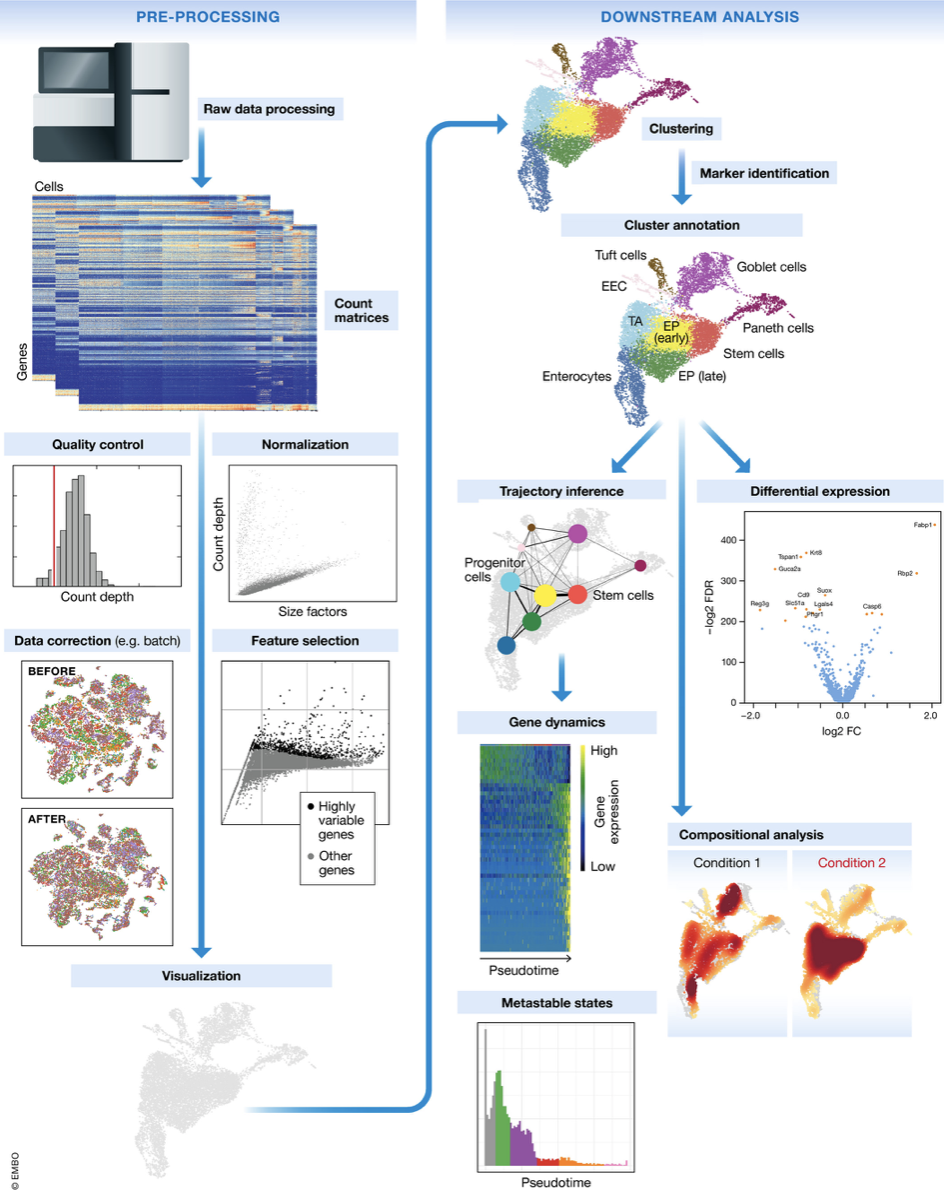

## 3.Vizualization
This dataset consists of many cell types, which were mostly identified as amacrine cells, Muller glia, rod bipolar cells, and many subtypes of cone Bipolar cells.

Let's visualize the data. We could use PCA but the data is too rich for PCA to resolve many of the cell types. Let's use two non-linear dimensionalilty reduction algorithms to visualize the data, named tSNE and UMAP. 

### 3.1. tSNE
t-SNE gets very slow with high-dimensional data. We can speed it up substantially by running PCA first to 100 dimensions and fewer cells.

In [ ]:
data_pca = scprep.reduce.pca(data_raw, n_components=100, method='dense')
data_pca_subsample, metadata_subsample = scprep.select.subsample(data_pca, metadata, n=3000)

In [ ]:
import sklearn.manifold
tsne_op = sklearn.manifold.TSNE()
data_tsne = tsne_op.fit_transform(data_pca_subsample)

In [ ]:
scprep.plot.scatter2d(data_tsne, c=metadata_subsample['CELLTYPE'],
                      figsize=(12,4), legend_anchor=(1,1),
                      ticks=False, label_prefix='t-SNE')

### 3.2. UMAP
Even though UMAP is not a part of scikit-learn, the syntax for UMAP is identical to t-SNE: `umap.UMAP().fit_transform`. UMAP is relatively fast, so you won't need to use the subsampled data. We also don't need to do PCA beforehand, but since we've already done it we may as well.

Note, there's an article called ["Understanding UMAP" by Google Research](https://pair-code.github.io/understanding-umap/) that explores the effect of various parameters of UMAP. 

In [ ]:
import umap
umap_op = umap.UMAP()
data_umap = umap_op.fit_transform(data_pca)

In [ ]:
scprep.plot.scatter2d(data_umap, c=metadata['CELLTYPE'],
                      figsize=(12,4), legend_anchor=(1,1), ticks=False, label_prefix='UMAP')

**NOTE:** tSNE and UMAP are starting to fall out of favor because they can be misleading since they don't preserve local or global structures in highly multidimentional data. Nonetheless, they do show some correlation with our data and are thus beneficial. See more at this preprint and twitter thread here: https://twitter.com/lpachter/status/1431325969411821572?s=20&t=aPuoayvEGiD8_mjplbY79w https://www.biorxiv.org/content/10.1101/2021.08.25.457696v3


## 4.Classification

#### Converting data to `numpy` format

PyTorch expects data to be stored as a NumPy array.

In [ ]:
data = scprep.reduce.pca(data_raw, n_components=50, method='dense').to_numpy()
data.shape
data[1:5, 1:5]

For optimal classification, we'll scale the data to have mean 0 and standard deviation 1 across all features. This is an important preliminary step for classification algorithms.

In [ ]:
data = data - data.mean(axis=0)
data = data / data.std(axis=0)
data[1:5, 1:5]

In [ ]:
metadata['CELLTYPE']

In [ ]:
labels, cluster_names = pd.factorize(metadata['CELLTYPE'])
labels

In [ ]:
num_classes = len(np.unique(labels))

In [ ]:
print(np.unique(labels))
print(num_classes)

#### Splitting the data into training and testing (validation) sets

We'll allocate 80\% of our data for training and 20\% for testing. You can also do this with scikit-learn:

```python
from sklearn.model_selection import train_test_split
data_training, data_validation, labels_training, labels_validation = train_test_split(
    data, labels, test_size=0.2)
```

In [ ]:
# first let's split our data into training and validation sets
train_test_split = int(.8 * data.shape[0])

data_training = data[:train_test_split, :]
labels_training = labels[:train_test_split]
data_validation = data[train_test_split:, :]
labels_validation = labels[train_test_split:]
data_training.shape, data_validation.shape

## 4.1 Moving Our Data to PyTorch Tensors 

By moving our data from numpy arrays to PyTorch Tensors, we can take advantage of the variety of tensor operations available. 

In [ ]:
train_tensor = torch.from_numpy(data_training)
train_labels = torch.from_numpy(labels_training)

valid_tensor = torch.from_numpy(data_validation)
valid_labels = torch.from_numpy(labels_validation)

Let's go ahead and check that our tensors are the expected sizes. We can do this identically to how we've previously done it with numpy arrays

In [ ]:
# check shapes
print("training set tensor shape: {}".format(train_tensor.shape))
print("training set labels shape: {}".format(train_labels.shape))

print("validation set tensor shape: {}".format(valid_tensor.shape))
print("validation set labels shape: {}".format(valid_labels.shape))

## Tensor operations quick explanation: Operations are similar to numpy arrays

1. Create a tensor called x of values (0, 1, ..., 18, 19) using torch.arange(). Check the PyTorch documentation for [help](https://pytorch.org/docs/master/generated/torch.arange.html)

2. Reshape this tensor to shape (4,5)

2. Add the constant 5 to x and save this tensor as y

3. Power the values of y to 3rd power and save this tensor as z

4. Print the first row of z



In [ ]:
# create x using torch.arange()
x = torch.arange(20)
print(x)

# reshape to (4,5)
x = x.reshape(4,5)
print(x)

# add 5
y = x + 5
print(y)

# power y to the 3rd power
z = y ** 3
print(z)

# print the last two rows of z
print(z[-2:])

## 4.2 Building a one-layer neural network

Now we know how to write simple recipes in PyTorch, we can create a more complex instruction set defining a simple neural network with a single hidden layer.

In [ ]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = nn.Parameter(torch.randn(input_size, output_size).double(), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(output_size).double(), requires_grad=True)
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias # matmul refers to matrix multiplication of two vectors
        if self.activation is not None:
            output = self.activation(output)
        return output

Now, we can make two copies of this layer and stack them together to make a simple neural network.

In [ ]:
# num_classes refers to number of cell types. In our case, 29 cell types in the retina
input_size = data_training.shape[1]
print(input_size)
print(num_classes)
num_hidden = 10

layer_1 = layer(input_size, num_hidden, activation=nn.ReLU()) 
# ReLu is just an activation function, rectified linear unit function 
# More info: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1)) 
# nn.Softmax refers to applying the softmax function to an n-dimensional input tensor.
# The softmax function rescales the input such that the output n-dimensional lays in the range [0,1] and sum to 1.
# -1 referst to the last dimension

# create a hidden (middle) layer
hidden_layer = layer_1(train_tensor)

# create the output layer used to classify
output = layer_2(hidden_layer)

output
output.size()

#### 4.2.1. Build the loss function

In order to train our neural network, we need to define a loss function. 

Here, we'll use the cross-entropy loss. 

In [ ]:
def to_one_hot(y_tensor, c_dims):
    """converts a N-dimensional input to a NxC dimnensional one-hot encoding
    """
    y_tensor = torch.LongTensor(y_tensor)
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    c_dims = c_dims if c_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], c_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y_tensor.shape, -1)
    return y_one_hot.squeeze()

In [ ]:
# convert our integer class labels to a binary "one-hot" matrix
labels_one_hot = to_one_hot(train_labels, num_classes)
labels_one_hot

In [ ]:
# compute cross entropy
loss = labels_one_hot * torch.log(output+ 1e-6) + (1 - labels_one_hot) * torch.log(1 - output + 1e-6)
loss = -1 * loss.sum()
loss

#### 4.2.2. Creating a model with PyTorch

Now let's use some PyTorch magic and create a model using `nn.Sequential`, which we can just treat as some fancy list for PyTorch layers. One of the benefits of this is that we can use `model.parameters()` to pull out the list of network parameters to be optimized.

In [ ]:
model = nn.Sequential(layer_1, layer_2)
print(model)

We can now obtain the output of our model by simply calling `model(data)`.

In [ ]:
model(train_tensor)

#### 4.2.3. Create the optimizer

To update the model parameters, PyTorch does all of the heavy lifting for us. The optimizer takes the loss value and calculates how we should change the network weights to improve our results.

In [ ]:
# now we need an optimizer that we'll give this loss, and it'll take responsibility
# for updating the network to make this score go down
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)


# how many data points do we want to calculate at once?
batch_size = 128

#### 4.2.4. Train the network

Let's train the network for 100 _epochs_. An epoch is defined as having optimized our weights over all of our data points exactly once.

In [ ]:
# train the network for 100 epochs
step = 0
print_every = 50
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(100):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

# Assignment 1 (1/7). Interpretation of results.

1. How did our network do? Is the classification accuracy high?   
A: 

2. How many iterations did it take for the training accuracy to stop increasing?  
A:

3. How many iterations did it take for the training loss to stop decreasing?  
A:

4. How many iterations did it take for the validation accuracy to stop increasing?   
A:


# Assignment 2 (2/7). Effect of network width.

Create a network with a wider hidden layer and compare its performance to the network with 10 hidden neurons we just built. 

In [ ]:
# let's set some hyperparameters
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
# ========
# Build the neural network with a wider than 10 hidden layer
num_hidden = # ADD CODE HERE
# ========

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2)

# create the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

# Assignment 3 (3/7). Effect of optimizers.

PyTorch provides a number of different optimizers for us to choose from. Replace `optim.SGD` with any of `optim.RMSprop`, `optim.Adagrad` and `optim.Adam` and experiment with the number of layers and hidden units to find the best possible network.

In [ ]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2)

# =========
# MODIFY HERE
# create the optimizer
optimizer = optim.???(
    model.parameters(),
    lr=learning_rate
)
# =========

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

# Assignment 4 (4/7). Effect of network depth.

Create a network with *two* hidden layers and compare its performance to the network with one hidden layer we just built. Try increasing the number of epochs if the loss hasn't stopped increasing.

In [ ]:
# let's set some hyperparameters
batch_size = 128
# ========
# as you add an additional layer, you may wish to decrease the learning rate
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.001
n_epochs = 100
# ========
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
# ========
# ADD CODE HERE
# Create an additional hidden layer
layer_2 =     ### here should be your input
# ========
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2, layer_3)

# create the optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

# Assignment 5 (5/7). Effect of activation functions.

PyTorch provides a number of different activations for us to choose from. Replace `nn.ReLU` with any of `nn.Tanh`, `nn.Sigmoid` and `nn.LeakyReLU` or any others you find in the PyTorch docs to build the best possible network.

In [ ]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# ======
# build the neural network with your choice of activation function

layer_1 = layer(
    input_size, num_hidden,
    activation=
)
layer_2 = layer(
    num_hidden, num_hidden, 
    activation=
)
# ======
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2, layer_3)

# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate
)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

# Assignment 6 (6/7). More about network depth.

Create a network with *five* hidden layers and compare its performance to the network with one hidden layer we just built

In [ ]:
# let's set some hyperparameters
batch_size = 128
# ========
# as you add further additional layers, you may wish to decrease the learning rate, e.g. to 0.0001
# if the network hasn't finished improving after 100 epochs, you can train it for longer
# ADD HERE
learning_rate = 
n_epochs = 

# ========
print_every = 50
num_hidden = 20

# ======
# build the neural network with five hidden layers
# ADD HERE
layer_1 = layer(
    input_size, num_hidden,
    activation=
)
layer_2 = layer(
    num_hidden, num_hidden, 
    activation=
)
layer_3 = 
layer_4 = 
layer_5 =

# ======

layer_6 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))


model = nn.Sequential(layer_1, layer_2, layer_3, layer_4, layer_5, layer_6)

# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

# Assignment 7 (7/7). Concluding interpretation of the results.

1. How did the more complex networks you built compare to the simple network we started with?
2. Which was more useful -- adding _depth_ to your network or adding width?
3. Which optimizer performed best?
4. What had the biggest effect on performance: depth, width, or optimizer?